In [69]:
import os
from glob import glob
import pandas as pd

# Load 'df_queries_filtered.csv' into a DataFrame
csv_path = "df_queries_filtered.csv"


# try to find the file if it's not in the current working directory
if not os.path.exists(csv_path):
    matches = glob("**/df_queries_filtered*.csv", recursive=True)
    if matches:
        csv_path = matches[0]
        print(f"Found CSV at: {csv_path}")
    else:
        raise FileNotFoundError(
            f"'{csv_path}' not found in {os.getcwd()}. Place the file there or update csv_path."
        )

# read the CSV (use low_memory=False to avoid dtype inference warnings)
df_queries = pd.read_csv(csv_path, low_memory=False)

# quick inspection
print(f"Loaded '{csv_path}' with shape: {df_queries.shape}")
print(df_queries.head())

# Define the 5 label options (global)
label_options = {
    0: "Broad / exploratory",
    1: "Price-constraints",
    2: "Feature-focused",
    3: "Brand/model comparisons",
    4: "Meta / strategy / explanation"
}
print("Defined label_options:", label_options)

Found CSV at: google_exports\df_queries_filtered.csv
Loaded 'google_exports\df_queries_filtered.csv' with shape: (127, 10)
                               query_id                            session_id  \
0  01dfe28b-a6a7-4b30-8a13-43e10bd5d085  1214eecf-5b2a-4675-9926-f06f9619dee8   
1  042b0b64-c626-4449-829a-4dd8d7532af8  1dd3d11a-dec8-4041-b981-8efab9dce7b4   
2  04aa2261-185f-4beb-bb95-ec0993cb08bf  1214eecf-5b2a-4675-9926-f06f9619dee8   
3  0744ba2a-a874-4126-a596-2ccf4c5a1574  ae444d00-9295-437f-812b-f75240800327   
4  07e24f82-f867-4794-afbd-b704031ee17d  21821039-baef-4c67-94ea-4099060a4805   

   query_order                        query_text query_structure  \
0            4                         iphone 15         keyword   
1            1  best smartphones under 400 euros     comparative   
2            3                       samsung s25         keyword   
3            2      eco friendly smartphone 2025         keyword   
4            1                Good quality phone  

## 1. Clustering GG query based on the query theme

In [ ]:
# Override embedding helpers to support both openai<1.0 and >=1.0 clients
from typing import List, Union
import numpy as np
import time
import logging
import openai


def embed_texts(texts: Union[str, List[str]], batch_size: int = 128, max_retries: int = 5, backoff_base: float = 1.5) -> np.ndarray:
    """
    Get embeddings for a single string or a list of strings using OpenAI embeddings API.
    Uses new client API when available (openai>=1.0), otherwise falls back to legacy (openai<1.0).
    Returns a NumPy array of shape (n_texts, embedding_dim).
    """
    if isinstance(texts, str):
        texts = [texts]
    texts = [("" if t is None else str(t)) for t in texts]

    embeddings: List[List[float]] = []
    for start in range(0, len(texts), batch_size):
        batch = texts[start:start + batch_size]
        for attempt in range(1, max_retries + 1):
            try:
                # Prefer the new API if available (openai>=1.0 exposes OpenAI)
# Heuristic labeling will be applied after clustering; ensure cluster assignments exist.
cluster_label_map = {}
if 'cluster_id' not in df.columns and 'kmeans' in globals():
    try:
        df['cluster_id'] = kmeans.labels_
        print('Added missing cluster_id from existing kmeans object.')
    except Exception as e:
        print('Could not derive cluster_id from kmeans:', e)
                if attempt == max_retries:
                    logging.error("Max retries reached for embedding request.")
                    raise
                sleep_time = backoff_base ** attempt
                logging.warning(f"Embedding request failed (attempt {attempt}/{max_retries}): {e}. Retrying in {sleep_time:.1f}s")
                time.sleep(sleep_time)

    return np.array(embeddings, dtype=np.float32)


def embed_series(series: pd.Series, **kwargs) -> np.ndarray:
    """Convenience wrapper to embed a pandas Series of text values using embed_texts above."""
    texts = series.fillna("").astype(str).tolist()
    return embed_texts(texts, **kwargs)
# Apply deterministic heuristic labeling overriding any incomplete fallback
def heuristic_label(texts):
    joined = ' '.join(texts).lower()
    scores = {i:0 for i in label_options.keys()}
    if re.search(r'\b(price|euro|under|budget|cheap|cost)\b', joined): scores[1]+=2
    if re.search(r'\b(compare|versus|vs|difference|model|brand)\b', joined): scores[3]+=2
    if re.search(r'\b(feature|camera|battery|spec|storage|display)\b', joined): scores[2]+=2
    if re.search(r'\b(strategy|how to|explain|guide|method)\b', joined): scores[4]+=2
    if max(scores.values())==0: scores[0]+=1
    return sorted(scores.items(), key=lambda x:(-x[1], x[0]))[0][0]
if 'cluster_id' in df.columns:
    texts = df[df['cluster_id']==cid]['query_text'].astype(str).tolist()[:100]
    lid = heuristic_label(texts)
    cluster_label_map[cid] = { 'cluster_id': cid, 'label_id': lid, 'label_name': label_options[lid] }
print('Final heuristic labels:', json.dumps(cluster_label_map, indent=2))
else:
    print('Skipping heuristic labeling: cluster_id column still missing.')

In [68]:
# Build unique example queries per cluster (case-insensitive, normalized)
import numpy as np, pandas as pd, re, matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

def normalize_text(s: str) -> str:
    s = str(s).casefold()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9]+", " ", s)
    return s.strip()

# Respect an existing EXAMPLES_PER_CLUSTER if defined elsewhere
try:
    EXAMPLES_PER_CLUSTER  # noqa: F821
except NameError:
    EXAMPLES_PER_CLUSTER = 5

# Ensure we have an 'embeddings' array. If not present, try to compute one:
# 1) If embed_series is available, attempt to use it (this may call OpenAI).
# 2) Otherwise, compute a TF-IDF + TruncatedSVD fallback so notebook runs offline.
if "embeddings" not in globals():
    print("Variable 'embeddings' not found. Creating fallback embeddings (TF-IDF + TruncatedSVD).")
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.decomposition import TruncatedSVD

    texts = df_queries["query_text"].fillna("").astype(str).tolist()
    vect = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
    X = vect.fit_transform(texts)

    # Choose SVD components reasonably (cannot exceed n_features - 1)
    n_components = min(128, X.shape[1] - 1) if X.shape[1] > 1 else 1
    if n_components < 1:
        # fallback to dense TF-IDF (rare)
        embeddings = np.asarray(X.todense(), dtype=np.float32)
    else:
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        embeddings = svd.fit_transform(X).astype(np.float32)
else:
    print("Using existing 'embeddings' variable from the notebook.")

# Now proceed with normalization and selecting examples per cluster
E = np.asarray(embeddings)
E_norm = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-12)

# Determine which column holds the cluster id (robust to different naming schemes)
cluster_col = next(
    (col for col in ["cluster", "cluster_id", "kmeans_cluster"] if col in df_queries.columns),
    None,
)
if cluster_col is None:
    raise KeyError("Could not find a cluster column in df_queries. Expected one of: 'cluster', 'cluster_id', 'kmeans_cluster'.")

examples_rows = []
closest_point_index = {}
for c in sorted(df_queries[cluster_col].unique()):
    idx = df_queries.index[df_queries[cluster_col] == c].to_numpy()
    if idx.size == 0:
        continue
    centroid = E_norm[idx].mean(axis=0)
    centroid = centroid / (np.linalg.norm(centroid) + 1e-12)
    sims = (E_norm[idx] @ centroid)
    order = np.argsort(-sims)
    seen_norm = set()
    rank = 0
    for local_i in order:
        gi = int(idx[local_i])
        qtxt = str(df_queries.loc[gi, "query_text"])
        norm = normalize_text(qtxt)
        if not norm or norm in seen_norm:
            continue
        seen_norm.add(norm)
        rank += 1
        # Use .get for cluster_theme to avoid KeyError if column not present
        cluster_theme = df_queries.loc[gi].get("cluster_theme", df_queries.loc[gi].get("theme", ""))
        examples_rows.append({
            "cluster": int(c),
            "cluster_theme": cluster_theme,
            "global_index": gi,
            "similarity_to_centroid": float(sims[local_i]),
            "rank": rank,
            "query_text": qtxt,
        })
        if rank == 1:
            closest_point_index[int(c)] = gi
        if rank >= EXAMPLES_PER_CLUSTER:
            break

cluster_examples = pd.DataFrame(examples_rows)
cluster_examples.to_csv("df_queries_cluster_examples.csv", index=False)
print("Saved df_queries_cluster_examples.csv (unique examples)")
for c in sorted(cluster_examples["cluster"].unique()):
    sub = cluster_examples[cluster_examples["cluster"] == c].sort_values("rank")
    label = sub["cluster_theme"].iloc[0] if len(sub) else ""
    print(f"Cluster {c} — {label} (k={len(sub)})")
    for _, r in sub.iterrows():
        print(f"  #{r['rank']}: {r['query_text']}")

Using existing 'embeddings' variable from the notebook.
Saved df_queries_cluster_examples.csv (unique examples)
Cluster 0 — Price-constraints (k=5)
  #1: Samsung galaxy s23
  #2: samsung s25
  #3: samsung s25 ultra
  #4: samsung s25 FE price
  #5: samsung s25 ultra review
Cluster 1 — Price-constraints (k=5)
  #1: Buy smartphone
  #2: Smartphone 300€
  #3: Smartphone 300€ Test
  #4: best smartphone 300€
  #5: Smartphone
Cluster 2 — Broad / exploratory (k=5)
  #1: iphone 15
  #2: iPhone 15 265
  #3: iphone 15 amazon
  #4: iPhone 15 256GB
  #5: Iphone 15 plus
Cluster 3 — Brand/model comparisons (k=5)
  #1: Iphone 17
  #2: Apple iphone 17
  #3: Iphone 17 pro
  #4: Iphone 16
  #5: iphone 17 pro max
Cluster 4 — Price-constraints (k=5)
  #1: smartphones under 799 euro
  #2: best smartphones under 400 euros
  #3: smartphone under £150
  #4: best smartphone 2025 under 500
  #5: Cheap smartphones


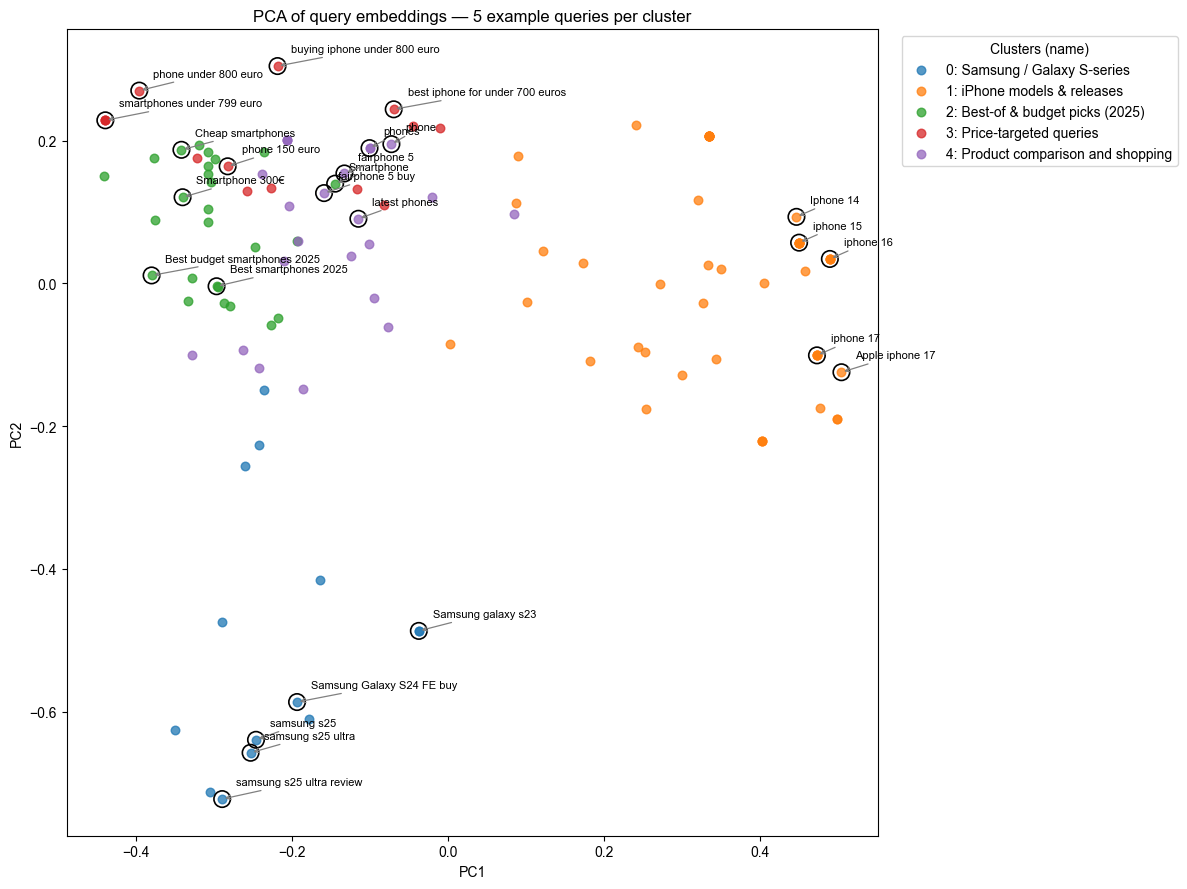

In [ ]:
# Plot with 5 example queries annotated per cluster (no cluster names in labels)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re

# Use Arial font for all text
plt.rcParams["font.family"] = "Arial"

def normalize_text(s: str) -> str:
    s = str(s).casefold()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9]+", " ", s)
    return s.strip()

# Ensure embeddings and 2D projection
E = np.asarray(embeddings)
E_norm = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-12)
try:
    emb2
except NameError:
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    emb2 = pca.fit_transform(E_norm)

# Ensure cluster_examples exists (top-K by centroid similarity, unique normalized query_texts)
try:
    cluster_examples
except NameError:
    EXAMPLES_PER_CLUSTER = 5
    examples_rows = []
    for c in sorted(df_queries["cluster"].unique()):
        idx = df_queries.index[df_queries["cluster"] == c].to_numpy()
        if idx.size == 0:
            continue
        centroid = E_norm[idx].mean(axis=0)
        centroid = centroid / (np.linalg.norm(centroid) + 1e-12)
        sims = (E_norm[idx] @ centroid)
        order = np.argsort(-sims)
        seen_norm = set()
        rank = 0
        for local_i in order:
            gi = int(idx[local_i])
            qtxt = str(df_queries.loc[gi, "query_text"])
            norm = normalize_text(qtxt)
            if not norm or norm in seen_norm:
                continue
            seen_norm.add(norm)
            rank += 1
            examples_rows.append({
                "cluster": int(c),
                "global_index": gi,
                "rank": rank,
                "query_text": qtxt,
            })
            if rank >= EXAMPLES_PER_CLUSTER:
                break
    import pandas as pd
    cluster_examples = pd.DataFrame(examples_rows)

# Build color map per cluster
unique_clusters = sorted(df_queries["cluster"].unique())
colors = list(plt.cm.tab10.colors)
cluster_color = {int(c): colors[i % len(colors)] for i, c in enumerate(unique_clusters)}

plt.figure(figsize=(12,9))
# Base scatter with legend using cluster names
for c in unique_clusters:
    mask = (df_queries["cluster"] == c).to_numpy()
    name = str(df_queries.loc[mask, "cluster_theme"].iloc[0]) if np.any(mask) else str(c)
    plt.scatter(
        emb2[mask, 0], emb2[mask, 1],
        s=38, alpha=0.75,
        color=cluster_color[int(c)],
        label=f"{int(c)}: {name}"
    )

# Annotate top-5 examples per cluster with only the query text (unique)
for c in unique_clusters:
    sub = cluster_examples[cluster_examples["cluster"] == int(c)].sort_values("rank").head(5)
    for _, r in sub.iterrows():
        gi = int(r["global_index"])
        x, y = emb2[gi]
        txt = str(df_queries.loc[gi, "query_text"]) if "query_text" in df_queries.columns else ""
        short = (txt[:60] + "…") if len(txt) > 60 else txt
        # ring highlight and text without cluster name and without box
        plt.scatter([x], [y], s=140, facecolors='none', edgecolors='black', linewidths=1.2)
        plt.annotate(
            f"{short}",
            xy=(x, y), xycoords='data',
            xytext=(10, 10), textcoords='offset points',
            fontsize=8,
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.9)
        )

plt.title("PCA of query embeddings — 5 example queries per cluster")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='Clusters (name)', frameon=True)
plt.tight_layout()
plt.show()

## 2. Clustering based on search process

In [9]:
pip install openai scikit-learn pandas python-dotenv numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [66]:
import os
import re
import json
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import openai
from sklearn.cluster import KMeans

# ======================================================
# 1. Load API key and client
# ======================================================
# load environment variables and set openai.api_key
load_dotenv()

api_key = os.getenv("OPENAI_API_KEY") or globals().get("OPENAI_API_KEY")
if not api_key:
    raise RuntimeError(
        "OPENAI_API_KEY is not set. Please define it in your environment "
        "or in the OPENAI_API_KEY notebook variable."
    )
openai.api_key = api_key

# ======================================================
# 2. Load your dataset
#    (Option A) direct from CSV
# ======================================================
df = df_queries.copy()

# If you already have df_queries in memory, you can instead do:
# df = df_queries.copy()

df["query_text"] = df["query_text"].astype(str)
queries = df["query_text"].tolist()

print("Total queries:", len(queries))

# ======================================================
# 3. Get OpenAI embeddings for all queries
# ======================================================
def get_embeddings(text_list, model="text-embedding-3-small", batch_size=100):
    all_embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        # Use module-level API (older openai package style)
        response = openai.Embedding.create(
            model=model,
            input=batch
        )
        # response['data'] contains dicts with 'embedding'
        all_embeddings.extend([item["embedding"] for item in response["data"]])
    return np.array(all_embeddings, dtype="float32")

embeddings = get_embeddings(queries)
print("Embeddings shape:", embeddings.shape)

# ======================================================
# 4. KMeans clustering into 5 clusters
# ======================================================
NUM_CLUSTERS = 5
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=20)
df["kmeans_cluster"] = kmeans.fit_predict(embeddings)

print("Cluster sizes (raw KMeans labels):")
print(df["kmeans_cluster"].value_counts().sort_index(), "\n")

# ======================================================
# 5. Define your 5 target themes
# ======================================================
label_options = {
    0: "Broad / exploratory",
    1: "Price-focused",
    2: "Feature-focused",
    3: "Brand/model comparisons",
    4: "Meta / strategy / explanation"
}

def build_prompt(cluster_id, examples):
    examples_str = "\n".join(f"- {q}" for q in examples)
    labels_str = "\n".join(f"{k}: {v}" for k, v in label_options.items())

    prompt = f"""
You are labelling clusters of smartphone-search queries.

Possible labels (label_id: description):
{labels_str}

Below are example queries from cluster {cluster_id}:

{examples_str}

Choose the SINGLE best label_id (0–4) that fits most queries.
Return ONLY this JSON object:

{{"kmeans_cluster": {cluster_id}, "label_id": X, "label_name": "..." }}
""".strip()
    return prompt

# ======================================================
# 6. Ask GPT to label each KMeans cluster
# ======================================================
cluster_label_map = {}   # kmeans_cluster -> {"label_id":.., "label_name":..}

for cid in range(NUM_CLUSTERS):
    examples = (
        df[df["kmeans_cluster"] == cid]["query_text"]
        .head(10)
        .tolist()
    )

    prompt = build_prompt(cid, examples)

    # Use ChatCompletion API (module-level) and extract content
    response = openai.ChatCompletion.create(
        model="gpt-4.1-mini",   # keep the same model name; change if unavailable
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
    )

    # compatible indexing for various openai versions
    try:
        raw = response["choices"][0]["message"]["content"].strip()
    except Exception:
        # fallback if object-like attributes are present
        raw = response.choices[0].message.content.strip()

    print(f"\nGPT output for KMeans cluster {cid}:\n{raw}\n")

    m = re.search(r"\{.*\}", raw, re.DOTALL)
    if not m:
        raise ValueError(f"Could not find JSON object in model output for cluster {cid}: {raw}")
    obj = json.loads(m.group(0))
    cluster_label_map[cid] = {
        "label_id": obj["label_id"],
        "label_name": obj["label_name"],
    }

print("Final mapping (kmeans_cluster → label_id: label_name):")
for cid, info in cluster_label_map.items():
    print(f"  {cid} → {info['label_id']}: {info['label_name']}")

# ======================================================
# 7. Attach final theme to every query
# ======================================================
def map_theme(cid):
    info = cluster_label_map[cid]
    return info["label_id"], info["label_name"]

df["theme_id"], df["theme_name"] = zip(
    *df["kmeans_cluster"].map(map_theme)
)

# theme_id is 0–4 according to your scheme
# theme_name is the human-readable label

print("\nPreview with themes:")
print(df[["query_text", "kmeans_cluster", "theme_id", "theme_name"]])

# ======================================================
# 8. Save the result
# ======================================================
#df.to_csv("df_queries_with_embedding_clusters_themes.csv", index=False)
#print("\nSaved: df_queries_with_embedding_clusters_themes.csv")


Total queries: 127
Embeddings shape: (127, 1536)
Embeddings shape: (127, 1536)
Cluster sizes (raw KMeans labels):
kmeans_cluster
0    44
1    34
2    17
3    17
4    15
Name: count, dtype: int64 

Cluster sizes (raw KMeans labels):
kmeans_cluster
0    44
1    34
2    17
3    17
4    15
Name: count, dtype: int64 


GPT output for KMeans cluster 0:
{"kmeans_cluster": 0, "label_id": 0, "label_name": "Broad / exploratory"}


GPT output for KMeans cluster 0:
{"kmeans_cluster": 0, "label_id": 0, "label_name": "Broad / exploratory"}


GPT output for KMeans cluster 1:
{"kmeans_cluster": 1, "label_id": 2, "label_name": "Feature-focused"}


GPT output for KMeans cluster 1:
{"kmeans_cluster": 1, "label_id": 2, "label_name": "Feature-focused"}


GPT output for KMeans cluster 2:
{"kmeans_cluster": 2, "label_id": 1, "label_name": "Price-focused"}


GPT output for KMeans cluster 2:
{"kmeans_cluster": 2, "label_id": 1, "label_name": "Price-focused"}


GPT output for KMeans cluster 3:
{"kmeans_cluster"

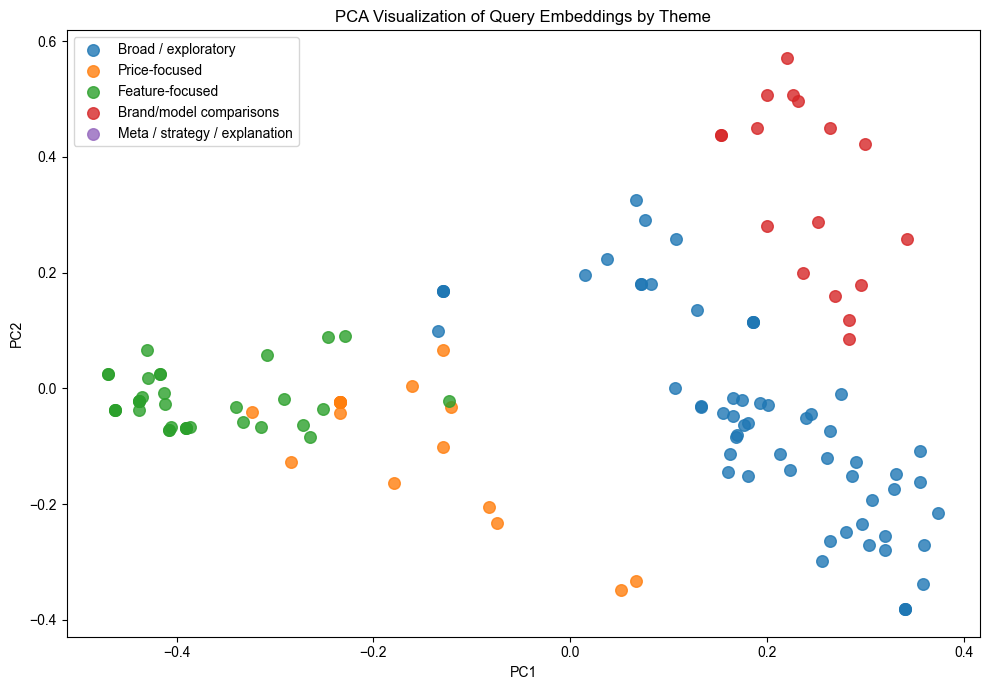

In [83]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Use the embeddings you already computed
X = embeddings

# Reduce to 2 dimensions
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

df["pc1"] = X_2d[:,0]
df["pc2"] = X_2d[:,1]

# Color mapping
theme_colors = {
    "Broad / exploratory": "#1f77b4",
    "Price-focused": "#ff7f0e",
    "Feature-focused": "#2ca02c",
    "Brand/model comparisons": "#d62728",
    "Meta / strategy / explanation": "#9467bd"
}

plt.figure(figsize=(10,7))
for theme, color in theme_colors.items():
    mask = df["theme_name"] == theme
    plt.scatter(df.loc[mask, "pc1"],
                df.loc[mask, "pc2"],
                s=70,
                alpha=0.8,
                label=theme,
                color=color)

plt.title("PCA Visualization of Query Embeddings by Theme")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


In [56]:
print(df.columns)

# Safely try to show theme_id/theme_name; if missing, try to construct sensible fallbacks
try:
	print(df[["theme_id", "theme_name"]].head())
except KeyError:
	# Fallback 1: map from kmeans_cluster using cluster_label_map (created earlier in notebook)
	if "kmeans_cluster" in df.columns and "cluster_label_map" in globals():
		print("Columns 'theme_id'/'theme_name' missing — deriving from 'kmeans_cluster' via cluster_label_map.")
		def _safe_get_label_id(cid):
			try:
				return cluster_label_map.get(int(cid), {}).get("label_id", np.nan)
			except Exception:
				return np.nan
		def _safe_get_label_name(cid):
			try:
				return cluster_label_map.get(int(cid), {}).get("label_name", "")
			except Exception:
				return ""
		df["theme_id"] = df["kmeans_cluster"].map(_safe_get_label_id)
		df["theme_name"] = df["kmeans_cluster"].map(_safe_get_label_name)
		print(df[["theme_id", "theme_name"]].head())
	# Fallback 2: use existing cluster_theme as theme_name and try to map cluster_id -> theme_id
	elif "cluster_theme" in df.columns:
		print("Columns missing — using 'cluster_theme' as 'theme_name'.")
		df["theme_name"] = df["cluster_theme"]
		if "cluster_label_map" in globals() and "cluster_id" in df.columns:
			def _get_id_from_cluster_id(cid):
				try:
					return cluster_label_map.get(int(cid), {}).get("label_id", np.nan)
				except Exception:
					return np.nan
			df["theme_id"] = df["cluster_id"].map(_get_id_from_cluster_id)
		else:
			df["theme_id"] = np.nan
		print(df[["theme_id", "theme_name"]].head())
	# Fallback 3: maybe the themes are stored in df_queries
	elif "df_queries" in globals() and {"theme_id", "theme_name"}.issubset(df_queries.columns):
		print("Pulling theme columns from df_queries.")
		df = df.merge(df_queries[["query_id", "theme_id", "theme_name"]], on="query_id", how="left")
		print(df[["theme_id", "theme_name"]].head())
	else:
		print("Could not find or derive 'theme_id'/'theme_name'. Available columns:", list(df.columns))

Index(['query_id', 'session_id', 'query_order', 'query_text',
       'query_structure', 'start_time', 'end_time', 'query_duration_sec',
       'click_count', 'query_duration_ms', 'cluster_id', 'cluster_theme'],
      dtype='object')
Columns missing — using 'cluster_theme' as 'theme_name'.
   theme_id           theme_name
0         1  Broad / exploratory
1         0    Price-constraints
2         0    Price-constraints
3         2    Price-constraints
4         2    Price-constraints


In [57]:
df_sorted = df.sort_values(["session_id", "query_order"])
transitions = []

for sid, group in df_sorted.groupby("session_id"):
    group = group.sort_values("query_order")
    prev = None
    for t in group["theme_id"]:
        if prev is not None:
            transitions.append((prev, t))
        prev = t

transitions_df = pd.DataFrame(transitions, columns=["from","to"])

# counts & probabilities
trans_counts = pd.crosstab(transitions_df["from"], transitions_df["to"])
trans_probs  = trans_counts.div(trans_counts.sum(axis=1), axis=0)

print("Transition counts:\n", trans_counts)
print("\nTransition probabilities:\n", trans_probs.round(3))


Transition counts:
 to     0  1   2  3
from              
0     14  1   1  2
1      0  4   1  1
2      3  1  34  2
3      1  3   3  4

Transition probabilities:
 to        0      1      2      3
from                            
0     0.778  0.056  0.056  0.111
1     0.000  0.667  0.167  0.167
2     0.075  0.025  0.850  0.050
3     0.091  0.273  0.273  0.364


In [58]:
# All possible theme IDs
all_themes = [0, 1, 2, 3, 4]

# Reindex transition counts to full 5x5 matrix
trans_counts_full = (
    trans_counts
    .reindex(index=all_themes, columns=all_themes, fill_value=0)
)

# Convert to probabilities
trans_probs_full = (
    trans_counts_full.div(trans_counts_full.sum(axis=1), axis=0)
)

In [59]:
# Build mapping dict from df (unique theme_id → theme_name)
theme_map = (
    df.drop_duplicates("theme_id")
      .set_index("theme_id")["theme_name"]
      .to_dict()
)

# Re-label rows and columns
trans_counts_named = trans_counts_full.rename(index=theme_map, columns=theme_map)
trans_probs_named  = trans_probs_full.rename(index=theme_map, columns=theme_map)

print("\n=== CLEAN TRANSITION COUNTS (5×5, named) ===")
print(trans_counts_named)

print("\n=== CLEAN TRANSITION PROBABILITIES (5×5, named) ===")
print(trans_probs_named.round(3))



=== CLEAN TRANSITION COUNTS (5×5, named) ===
to                       Price-constraints  Broad / exploratory  \
from                                                              
Price-constraints                       14                    1   
Broad / exploratory                      0                    4   
Price-constraints                        3                    1   
Brand/model comparisons                  1                    3   
4                                        0                    0   

to                       Price-constraints  Brand/model comparisons  4  
from                                                                    
Price-constraints                        1                        2  0  
Broad / exploratory                      1                        1  0  
Price-constraints                       34                        2  0  
Brand/model comparisons                  3                        4  0  
4                                        0    

In [60]:
df_sorted = df.sort_values(["session_id", "query_order"])

transitions = []

for sid, group in df_sorted.groupby("session_id"):
    group = group.sort_values("query_order")
    prev = None
    for t in group["theme_id"]:
        if prev is not None:
            transitions.append((prev, t))
        prev = t

transitions_df = pd.DataFrame(transitions, columns=["from","to"])


In [61]:
trans_counts = pd.crosstab(transitions_df["from"], transitions_df["to"])
trans_probs  = trans_counts.div(trans_counts.sum(axis=1), axis=0)


In [62]:
theme_map = (
    df[["theme_id", "theme_name"]]
      .drop_duplicates()
      .set_index("theme_id")["theme_name"]
      .to_dict()
)


In [63]:
ALL = [0,1,2,3,4]

trans_counts_full = (
    trans_counts.reindex(index=ALL, columns=ALL, fill_value=0)
)

trans_probs_full = (
    trans_counts_full.div(trans_counts_full.sum(axis=1), axis=0)
)


In [64]:
trans_counts_named = trans_counts_full.rename(index=theme_map, columns=theme_map)
trans_probs_named  = trans_probs_full.rename(index=theme_map, columns=theme_map)

print("\n=== Transition Counts (5×5, named) ===")
print(trans_counts_named)

print("\n=== Transition Probabilities (5×5, named) ===")
print(trans_probs_named.round(3))



=== Transition Counts (5×5, named) ===
to                       Price-constraints  Broad / exploratory  \
from                                                              
Price-constraints                       14                    1   
Broad / exploratory                      0                    4   
Price-constraints                        3                    1   
Brand/model comparisons                  1                    3   
4                                        0                    0   

to                       Price-constraints  Brand/model comparisons  4  
from                                                                    
Price-constraints                        1                        2  0  
Broad / exploratory                      1                        1  0  
Price-constraints                       34                        2  0  
Brand/model comparisons                  3                        4  0  
4                                        0          

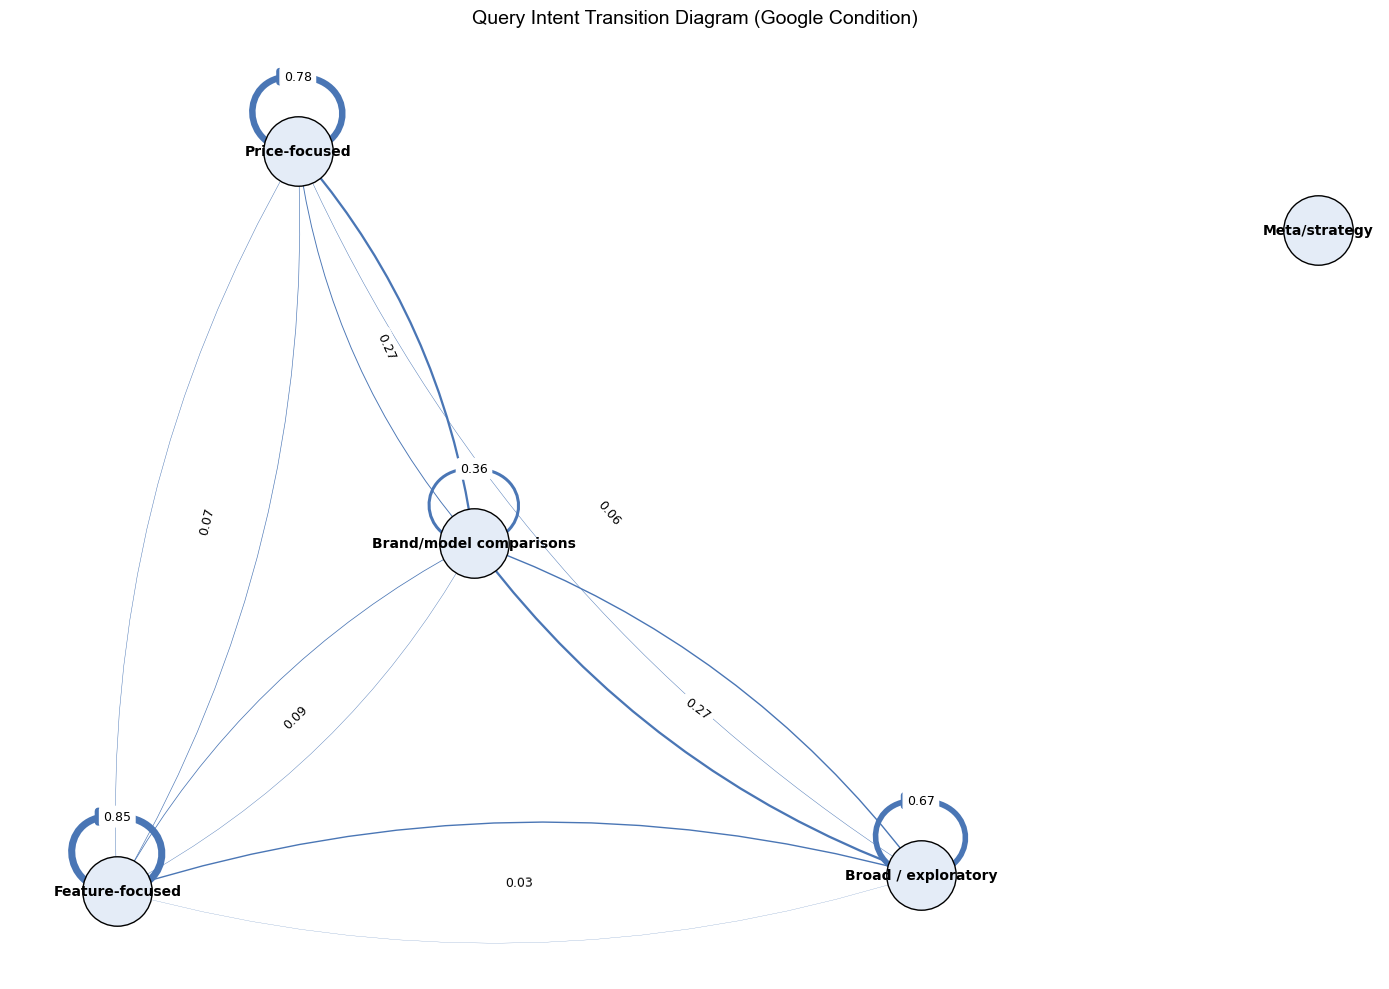

In [74]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# ============================================================
# Correct theme names
# ============================================================
theme_names = {
    0: "Price-focused",
    1: "Broad / exploratory",
    2: "Feature-focused",
    3: "Brand/model comparisons",
    4: "Meta/strategy"
}

# ============================================================
# Insert YOUR real transition probabilities here
# ============================================================
trans_probs = {
    0: {0: 0.778, 1: 0.056, 2: 0.056, 3: 0.111, 4: 0.0},
    1: {0: 0.000, 1: 0.667, 2: 0.167, 3: 0.167, 4: 0.0},
    2: {0: 0.075, 1: 0.025, 2: 0.850, 3: 0.050, 4: 0.0},
    3: {0: 0.273, 1: 0.273, 2: 0.091, 3: 0.364, 4: 0.0},
    4: {0: 0.0,   1: 0.0,   2: 0.0,   3: 0.0,   4: 0.0},  # Meta has no transitions
}

# ============================================================
# Build the directed graph
# ============================================================
G = nx.DiGraph()

# Add nodes
for tid, label in theme_names.items():
    G.add_node(label)

# Add edges (skip zero-probability edges)
for from_id, row in trans_probs.items():
    for to_id, prob in row.items():
        if prob > 0:
            G.add_edge(
                theme_names[from_id],
                theme_names[to_id],
                weight=prob,
                label=f"{prob:.2f}"
            )

# ============================================================
# Draw the diagram
# ============================================================
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=1.1)

weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
weights_scaled = 6 * weights   # adjust thickness

nx.draw_networkx_nodes(G, pos, node_size=2500,
                       node_color="#E4ECF7", edgecolors="black")

nx.draw_networkx_edges(G, pos,
                       arrowstyle="-|>",
                       arrowsize=20,
                       width=weights_scaled,
                       edge_color="#4A76B5",
                       connectionstyle="arc3,rad=0.15")

nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Query Intent Transition Diagram (Google Condition)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


“Given that the current query is in theme X, what is the probability that the next query will be in theme Y?”

1. **Strong self-loops:** people mostly stay in the same intent Look at the diagonal cells (darkest boxes): Broad / exploratory → Broad / exploratory ≈ 0.67 Price-focused → Price-focused ≈ 0.78 Feature-focused → Feature-focused ≈ 0.85 Brand/model comparisons → Brand/model comparisons ≈ 0.36 Interpretation: Once users are in a given “mode” (browsing broadly, thinking about price, focusing on features, or comparing models), they usually rewrite or refine queries within that same intent rather than immediately switching to a different type of query.

2. **Broad → Price & Brand:** narrowing after exploration Row “Broad / exploratory”: 67% Broad → Broad (stay broad) 17% Broad → Price-focused 17% Broad → Brand/model comparisons Interpretation: Starting from broad exploration, the two most common “next steps” are to introduce a price focus or to jump into brand/model comparisons. So exploration is both a stable state and a gateway into more constrained searches.

3. **Price-focused → Brand/model comparisons:** from budget to options Row “Price-constraints” (first row): 78% stay Price-focused 11% Price-focused → Brand/model comparisons 6% Price-focused → Broad Interpretation: When users are thinking in terms of budget (“under 400€”, “cheap phone”), they mostly continue querying within this price frame, but about 1 in 10 transitions move into explicit model comparisons, consistent with a path like: “phones under 400€” → “Samsung A55 vs Pixel 7a”.

4. **Feature-focused** → mostly stay in feature mode Row that should be Feature-focused (second repeated “Price-constraints” row): ≈85% stay Feature-focused Small spillovers to Price, Broad, Brand (each <10%) Interpretation: Once users start focusing on specific specs (camera, battery, etc.), they typically stay on that dimension for the next query — e.g. “good camera phone” → “night photography test” → “best selfie camera phone 2024”.

5. **Brand/model comparisons ↔ Broad & Price:** late-stage but not final Row “Brand/model comparisons”: 36% stay in Brand/model comparisons 27% Brand → Broad 27% Brand → Price-focused Interpretation: Comparison queries represent a more advanced decision stage, but it’s not the final one. After comparing two phones, people often either: go back to broad exploration (checking other families), or go back to price thinking (re-evaluating whether the compared models fit their budget).

6. **Meta / strategy** queries are almost absent The blank last row/column (label “4 –”) tells you: In this Google dataset there are essentially no meta/strategy transitions (queries like “how to choose a smartphone”, “what to look for”). They are extremely rare and do not form a stable “state” in the search process.

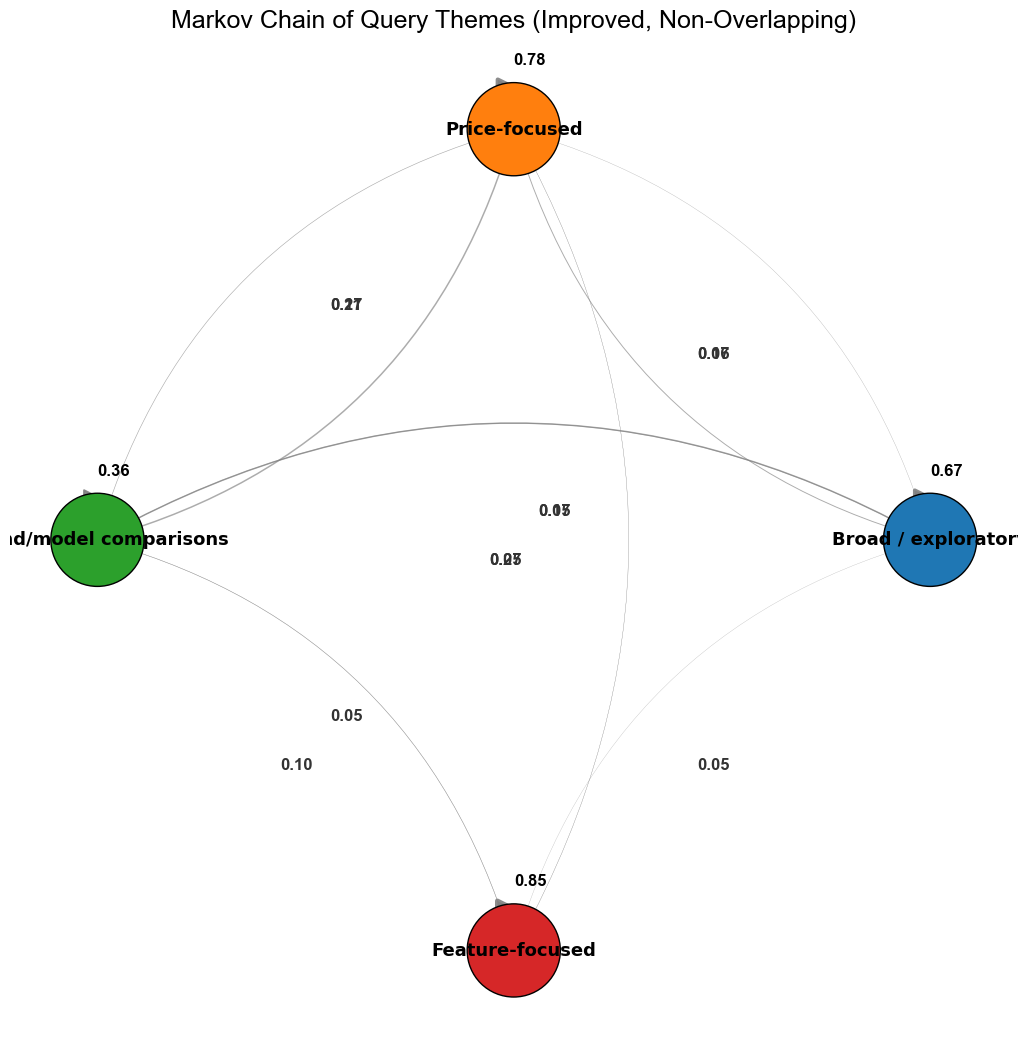

In [103]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Full category names
states = [
    "Broad / exploratory",
    "Price-focused",
    "Feature-focused",
    "Brand/model comparisons",
]

# Transition probabilities
P = [
    [0.67, 0.17, 0.00, 0.17],
    [0.06, 0.78, 0.05, 0.11],
    [0.05, 0.05, 0.85, 0.05],
    [0.27, 0.27, 0.10, 0.36]
]

theme_colors = {
    "Broad / exploratory": "#1f77b4",
    "Price-focused": "#ff7f0e",
    "Feature-focused": "#2ca02c",
    "Brand/model comparisons": "#d62728"
}

# Create graph
G = nx.DiGraph()

for i, s_from in enumerate(states):
    for j, s_to in enumerate(states):
        weight = P[i][j]
        if weight > 0:
            G.add_edge(s_from, s_to, weight=weight)

# Circular layout, larger radius to separate text
base_pos = nx.circular_layout(G)
pos = {k: v * 1.4 for k, v in base_pos.items()}

plt.figure(figsize=(13, 13))
ax = plt.gca()
ax.set_title("Markov Chain of Query Themes (Improved, Non-Overlapping)", fontsize=18)

# Draw nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=4500,
    node_color=[theme_colors[s] for s in states],
    edgecolors="black"
)

# Node labels
nx.draw_networkx_labels(
    G, pos,
    font_size=13,
    font_weight="bold"
)

# Curvature mapping (separates arcs cleanly)
curvatures = {
    (True, True): 0.35,   # self-loops handled separately
    (False, False): 0.25  # large arcs
}

# Draw edges
for (u, v, d) in G.edges(data=True):

    wt = d['weight']
    width = 4 * wt

    # Self-loops
    if u == v:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v)],
            width=width,
            arrows=True,
            arrowsize=20,
            connectionstyle="arc3,rad=0.45",
            edge_color="gray",
            alpha=0.9
        )
        # Label position: slightly above the node
        x, y = pos[u]
        plt.text(
            x, y + 0.22, f"{wt:.2f}",
            fontsize=12, fontweight="bold"
        )
        continue

    # Alternating curvature to avoid overlaps
    if list(G.edges()).index((u, v)) % 2 == 0:
        rad = 0.28
    else:
        rad = -0.28

    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        width=width,
        arrows=True,
        arrowsize=20,
        connectionstyle=f"arc3,rad={rad}",
        edge_color="gray",
        alpha=0.65
    )

    # Compute midpoint of curve for label
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    xm = (x1 + x2) / 2 + rad * 0.3  # offset label along curvature
    ym = (y1 + y2) / 2 + rad * 0.3
    plt.text(
        xm, ym,
        f"{wt:.2f}",
        fontsize=12,
        fontweight="bold",
        color="#333"
    )

plt.axis("off")
plt.show()
